## Interacting with Black Boxes in Assignment 2 
This notebook demonstrates how to interact with the '`Boxes`' objects that you will work with in assignment 2. It also includes examples of using the `.fft` and `.fftfreq` functions. See also the document `Yr2_computing_System_Identification.pdf` on Canvas.

Start by executing the code cell below which loads the example `Boxes` object `example_box` that represents some unknown electronic circuit.

In [1]:
# Doing all the imports in one go
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Setting global plotting settings
plt.rcParams['font.size'] = 20

# Creating an example `Box' object to play with 
# `Boxes' is part of the assignment module provided
from module_engine.assignment import Boxes 
example_box = Boxes.get_example_box() 

 ** Using temporary ID. Switch to your own ID as soon as possible. **


### Generating an input signal
The `box` object represents a 'black box', i.e. an unknown system. The system accepts an input signal and provides an output signal in return. By generating custom input signals for a specific box and analysing the output you can investigate the unknown system.

For the purposes of this example we generate a signal representing an input voltage over time. The signal is generated as a sine wave whose frequency is slowly changed from f1 to f2. In assignment 2, you should consider creating similar signals to probe the behaviour of each box.

In [2]:
def swept_sine(f1, f2, t):
    """ 
    create a sine wave with a frequency sweeping between f1 and f2
    f1: start frequency [Hz]
    f2: stop frequency [Hz]
    t: np.array of linearly spaced points in time [s]
    """
    f = np.linspace(f1,f2,t.size)
    output = np.sin(2*np.pi*f*t)
    return output

In order to generate the input signal we first make an array of times (`t`) at which the signal should be created.

We want to sample the signal on the interval $[0,10)$ seconds with $N = 1000$ sample points, resulting in a spacing between sample points of  
`timestep` $= \frac{10}{1000} = 0.01$ s. 

If you think about this in the frequency domain, this choice corresponds to a maximum sampling frequency of $\frac{1}{0.01} = 100$ Hz (i.e. 100 samples per second).

In [3]:
# Sampling a signal correctly is a bit tricky, you need
# to make sure you know the total time, timestep and number
# of points accuractely. If in doubt, compute these from the
# time array you created and print the result.

def get_time_array(N=1000, duration=10, endpoint=False):
    # N: Number of sample points
    # duration: end point of the open interval
    
    t = np.linspace(0, duration, num=N, endpoint=endpoint) 
    total_time = t[-1]-t[0] # different from duration!!
    timestep = total_time/(N-1) 
    print("Data points = {}".format(N))
    print("Total time = {} s".format(total_time))
    print("Timestep = {} s".format(timestep))
    print("Sampling Frequency = {} Hz".format((1/timestep)))
    
    return t

# generate time array
t = get_time_array(N=1000, duration = 10.0)

# generate array containing input signal (voltage) 
s_in = swept_sine(1,10,t)

Data points = 1000
Total time = 9.99 s
Timestep = 0.01 s
Sampling Frequency = 100.0 Hz


Note the `endpoint=False` keyword parameter. Without it, `np.linspace` includes the endpoint which would give the unexpected spacing of $1000/999 = 0.01001...$. (The spacing of any numpy array can also be checked using the `numpy.diff` function: `numpy.diff(t)` returns an array containing the difference between successive elements of `t`.)

We now have an input signal. Let's have a look at it.

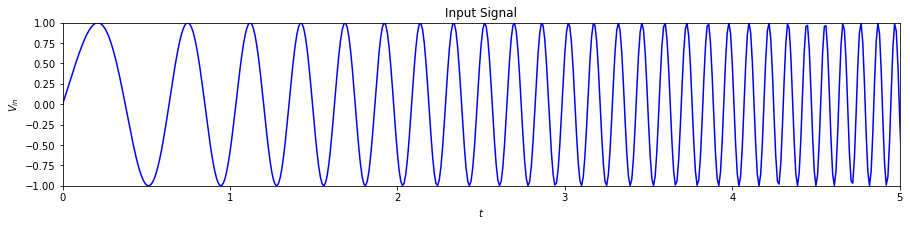

In [4]:
fig = plt.figure(figsize=(15,3))

# Plot input voltage as a function of time
plt.plot(t, s_in, 'b-')
plt.title('Input Signal') 
plt.xlabel(r'$t$') 
plt.ylabel(r'$V_{in}$')
plt.axis([0, 5, np.amin(s_in), np.amax(s_in)])
plt.show()

### Probing the box
In the cell, the call `example_box.process(t, s_in)` passes our voltage signal through the first box and returns the corresponding output signal, stored in the variable `s_out`. It is essential that the sample points described in `t` are **equally** spaced. 

Both arrays are then plotted on the interval $[0, 5]$ in the time domain. 

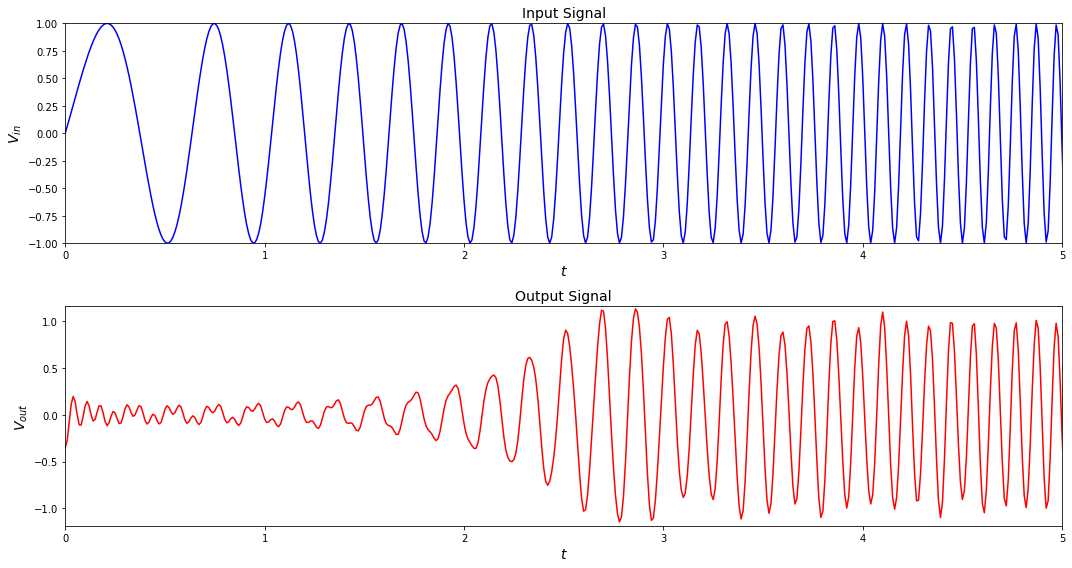

In [5]:
# Pass input signal through the example_box
# and create an output signal (voltage):
s_out = example_box.process(t, s_in)

# And plot the result, comparing input to output
fig = plt.figure(figsize=(15,8))
# Plot input voltage as a function of time
plt.subplot(211)
plt.plot(t, s_in, 'b-')
plt.title('Input Signal', fontsize=14) 
plt.xlabel(r'$t$', fontsize=14) 
plt.ylabel(r'$V_{in}$', fontsize=14)
plt.axis([0, 5, np.amin(s_in), np.amax(s_in)])

# Plot output voltage as a function of time
plt.subplot(212)
plt.plot(t, s_out, 'r-')
plt.title('Output Signal', fontsize=14)
plt.xlabel(r'$t$', fontsize=14) 
plt.ylabel(r'$V_{out}$', fontsize=14) 
plt.axis([0, 5, np.amin(s_out), np.amax(s_out)])

# Automatically adjust subplots to fit figure area
plt.tight_layout()
# Display plots
plt.show()

The signal has certainly been modified by `example_box`, but it is not yet entirely clear *how*. This type of investigation is often simpler and more intuitive when describing the signals as a function of frequency, i.e. by using the *frequency domain*.

To do so, we perform an Fourier Transform (using a DFT algorithm) on both the input and output signals and plot the resulting *spectra*.

As described in `Yr2_Computing_System_Identification.pdf`, the function `.fftfreq` is used to determine the relevant sample frequencies, and we choose to plot the positive frequency terms only.

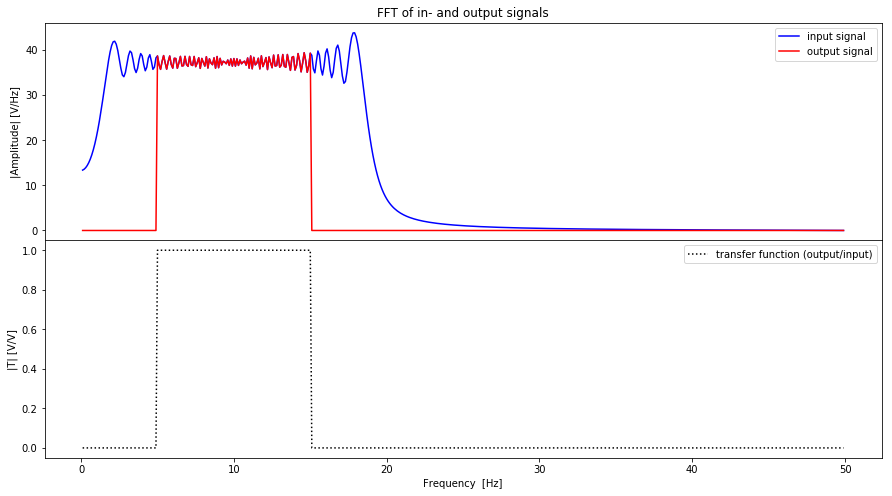

In [6]:
# Perform the Fourier Tranform on both signals
S_in = np.fft.fft(s_in)
S_out = np.fft.fft(s_out)

# Next we generate sample points in the frequency domain,
# for this we need to know the duration and time step
# of the time array.
def get_frequency_array(t):
    N = len(t)
    timestep = np.diff(t)[0]
    f = np.fft.fftfreq(N, d=timestep)
    return f

f = get_frequency_array(t)

# We only want to plot the positive frequencies from the FFT
# this means we can ignore half of each array.
# Check the numpy.fftfreq documentation to see that 
# frequencies are arranged as follows:
# f = [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (d*n)  if n is even
# so we are interested in the elements f[1:n/2].
def get_positive_frequencies(A):
    N=len(A)
    if len(A)//2==0:
        N2=int(N/2)
    else:
        N2=int((N+1)/2)
    return A[1:N2]

f = get_positive_frequencies(f)
S_in = get_positive_frequencies(S_in)
S_out = get_positive_frequencies(S_out)

# Creating some custom subplots
fg, ax = plt.subplots(2,1, figsize=(15,8), sharex=True)

# Plot the absolute values of transformed_output 
ax[0].plot(f, np.abs(S_in), 'b-', label='input signal') 
ax[0].plot(f, np.abs(S_out), 'r-', label='output signal')
ax[0].legend()

ax[1].plot(f, np.abs(S_out/S_in), 'k:', label='transfer function (output/input)')
ax[1].set_xlabel('Frequency  [Hz]')
ax[1].set_ylabel('|T| [V/V]')
ax[1].legend()

ax[0].set_title('FFT of in- and output signals')
ax[0].set_ylabel('|Amplitude| [V/Hz]')

# Fine-tune figure; make subplots close to each other 
# and hide x ticks for top plot.
fg.subplots_adjust(hspace=0)
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.show()

By dividing the output by the input we can generate very clean data showing the effect of the box independent of the details of the input signal we used. This ratio is called the **transfer function** of the system, sometimes also called **frequency response**.

We can see that the box had an effect similar to that of an ideal *band pass* filter: Our original signal contains frequencies ranging from $1$ to $20$ Hz (see `S_in`), while the output signal only those from $5$ to $15$ Hz; frequencies outside this range are completely blocked. 

You might be curious why our input signal contains significant amplitudes up to frequencies of $20$ Hz even though we specified f2=$10$ Hz. This is because our `swept_sine` function is just a quick and simple way of creating such a signal. We could instead use a true linear chirp, see the example at the end of this notebook. However, for  assignment 2 the exact shape of the signal does not matter.

Additional Notes:
- In order to complete the first task of assignment 2, you will want to perform the Fourier Transform on the input and output signals as above and calculate the transfer function as their element-wise ratio, `.fft(output_signal)/.fft(input_signal)` in order to determine the type of circuit contained inside each box.
- As stated earlier, be sure to investigate a broad range of frequencies with your input signal: 10 - 4000 Hz should be sufficient for Task 1. Additionally, check that your sample interval and number of sample points ($N$) are such that the sample interval in the frequency domains covers all of these frequencies.
- While the above plots use linear scales, in some cases logarithmic scaling is preferable. For circuits it is also common to plot the transfer function in decibels with a logarithmic horizontal axis. In general: if you are not able to discern anything meaningful from a plot, try using a different axis scaling. For assignment 2, read the instructions carefully and make sure you use the required axis scaling and formatting. 

## For the curious: how to make a linear chirp
For the tasks in assignment 2 the exact shape of the input signal is not important as long as it contains non-zero amplitudes in the frequency  range of interest. The function `swept_sine` above is a simple way of creating such an input signal. You will have noted above that the output signal of that function shows non-zero amplitudes up to 2 times the maximum frequency (as shown by the Fourier Transform). If you want to create a true linear chirp signal whose frequency sweeps linearly from $f_1$ to $f_2$ you can use the following function. More information on chirp signals can be found online but the short explanation is that the argument of the `sine` function is the phase $\phi$ and the frequency of a sine is defined as $1/2\pi\,df/d\phi$. Therefore, to create a frequency that increases linear in time, the phase $\phi$ must be a quadratic function of time.

In [7]:
def linear_chirp(f1, f2, t):
    """ 
    create a linear chirp with a frequency sweeping between f1 and f2
    f1: start frequency [Hz]
    f2: stop frequency [Hz]
    t: np.array of linearly spaced points in time [s]
    """
    k=(f2-f1)/(t[-1]-t[0])
    output = np.sin(2*np.pi*(f1*t + k/2.0*t*t))
    return output

Let's try it out:

Data points = 500
Total time = 9.98 s
Timestep = 0.02 s
Sampling Frequency = 50.0 Hz


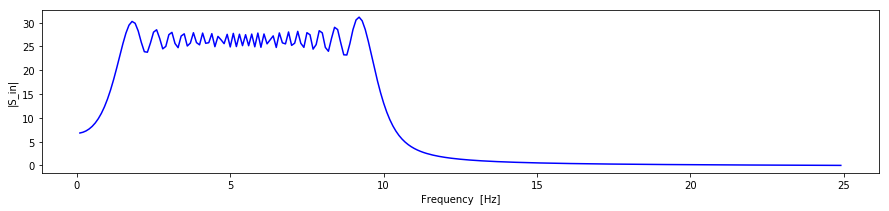

In [8]:
t = get_time_array(N = 500, duration = 10)
s_in = linear_chirp(1,10,t)

f = get_frequency_array(t)
S_in = np.fft.fft(s_in)

f = get_positive_frequencies(f)
S_in = get_positive_frequencies(S_in)

fig = plt.figure(figsize=(15,3))
plt.plot(f, np.abs(S_in), 'b-') 
plt.xlabel('Frequency  [Hz]')
plt.ylabel('|S_in|')
plt.show()